In [40]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 

### Read the dataset

In [41]:
df = pd.read_csv("diagnosis.csv")

### 1- Perform all necessary preprocessing steps to clean the dataset

In [42]:
df.head()

,0,1,2,3,4,5,6,7
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


- Accourding to  [UCI](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations) the attributes are the following :
| Column | Attribute | Values | 
| --- | --- | --- |
| 0 | Temperature of patient | 35C-42C | 
| 1 | Occurrence of nausea | yes, no | 
| 2 | Lumbar pain | yes, no | 
| 3 | Urine pushing (continuous need for urination) | yes, no | 
| 4 | Micturition pains | yes, no | 
| 5 | Burning of urethra, itch, swelling of urethra outlet | yes, no | 
| 6 | decision: Inflammation of urinary bladder | yes, no | 
| 7 | decision: Nephritis of renal pelvis origin | yes, no | 

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       120 non-null    float64
 1   1       120 non-null    int64  
 2   2       120 non-null    int64  
 3   3       120 non-null    int64  
 4   4       120 non-null    int64  
 5   5       120 non-null    int64  
 6   6       120 non-null    int64  
 7   7       120 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 7.6 KB


- it looks like the data is already encoded and normalize, let's check for outliers and irrelevant features.

- The columns numbered 1 to 7 in the dataset contain binary categorical values that have been encoded as 0s and 1s. Since these are binary values, it may not be meaningful to check for outliers using a boxplot. Instead, we can focus on checking for outliers in the first column, which represents the temperature of the patient.

<AxesSubplot:>

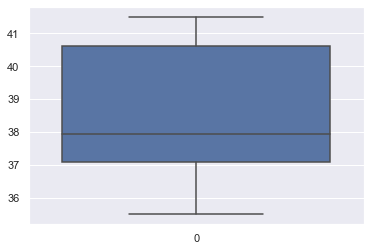

In [44]:
sns.set_theme()
sns.boxplot(data = df["0"])

- There are no visible outliers on the boxplot

<AxesSubplot:>

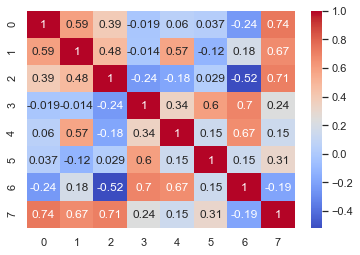

In [45]:
# check for correlationb
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm")

- you can see that column 7 (Nephritis of renal pelvis origin) is highly correlated with three other features 0, 1 and 2, also columns 4 is higly correlated with 1 and 3 with 5, so we will drop columns 1, 3, 7

In [46]:
df.drop(['1', '3', '7'],  axis = 1, inplace = True)

### 2-  Determine the optimal size of training dataset using the K-NN algorithm 

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

test_sizes = [x/100 for x in range(10,95,5)] 

# split to target and features 
y = df["6"]
X = df.drop("6", axis = 1)

# keep record of training size and accuracy
training_acc = {}

# load KNN classifier k = number of class = 2
knn = KNeighborsClassifier(n_neighbors = 2)

for size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = 42)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    acc_score = accuracy_score(y_test, pred) * 100
    training_size = int(round(1-size,2)*100)
    training_acc[training_size] = acc_score

Text(0.5, 0, 'Training Size %')

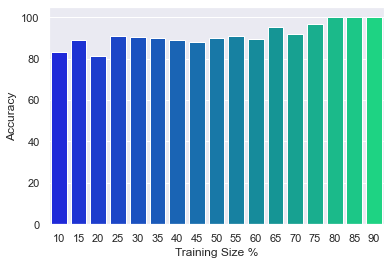

In [109]:
sns.barplot(x = list(training_acc.keys()), y = list(training_acc.values()), palette = "winter")
plt.ylabel("Accuracy")
plt.xlabel("Training Size %")

- the best sizes for training are 80%, 85%, and 90% of the total dataset

### 3-  Compute the distance between two data points using Euclidean distance

In [14]:
def euclidean_distance(point1, point2):
    """
    Compute the Euclidean distance between two data points.

    :param point1: An array representing the first data point.
    :param point2: An array representing the second data point.

    :return: The Euclidean distance between the two data points.
    """
    return sqrt(np.sum((point1 - point2) ** 2))

In [15]:
def knn(x_train, y_train, x_test, k):
    """
    Predict the class of a test point using the K-NN algorithm.

    :param x_train: An array of training data.
    :param y_train: An array of labels for the training data.
    :param x_test: An array representing the test point.
    :param k: The number of neighbors to consider.

    :return: The predicted class of the test point.
    """
    distances = np.zeros(x_train.shape[0])
    for i in range(x_train.shape[0]):
        distances[i] = euclidean_distance(x_train[i], x_test)
    indices = np.argsort(distances)
    class_votes = np.zeros(int(np.max(y_train)) + 1)
    for i in range(k):
        class_votes[int(y_train[indices[i]])] += 1
    return np.argmax(class_votes)

In [16]:
def cross_validate(x, y, k):
    """
    Perform ten-fold cross validation on the data using the K-NN algorithm.

    :param x: An array of data.
    :param y: An array of labels for the data.
    :param k: The number of neighbors to consider.

    :return: A list of accuracies for each fold.
    """
    kf = KFold(n_splits=10)
    accuracies = []
    for train_indices, test_indices in kf.split(x):
        x_train = x[train_indices]
        y_train = y[train_indices]
        x_test = x[test_indices]
        y_test = y[test_indices]
        y_pred = np.zeros(x_test.shape[0])
        for i in range(x_test.shape[0]):
            y_pred[i] = knn(x_train, y_train, x_test[i], k)
        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)
    return accuracies

In [31]:
data = df.values
x = data[:,1:]
y = np.array([x[0] for x in data[:,:1]])
accuracies = cross_validate(x, y, 15)
accuracies

[0.0,
 0.3333333333333333,
 0.08333333333333333,
 0.0,
 0.0,
 0.16666666666666666,
 0.25,
 0.0,
 0.0,
 0.0]

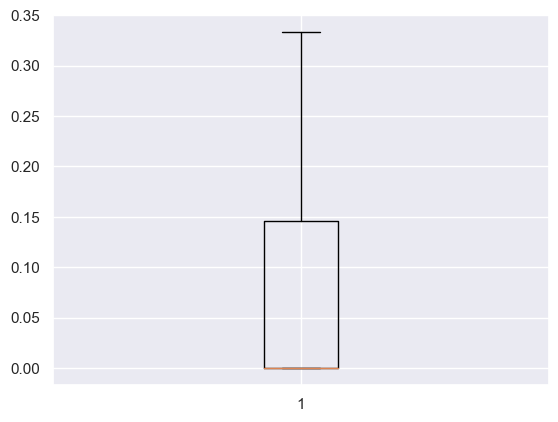

In [30]:
plt.boxplot(accuracies)
plt.show()

### 4- Compute the similarity between two data points using Cosine similarity

In [37]:
def cosine_similarity(point1, point2):
    """
    Compute the similarity between two data points using the reciprocal of the Euclidean distance.

    :param point1: An array representing the first data point.
    :param point2: An array representing the second data point.

    :return: The similarity between the two data points.
    """
    distance = euclidean_distance(point1, point2)
    if distance == 0:
        return float('inf')
    return 1 / distance

In [38]:
def knn_cosine(x_train, y_train, x_test, k):
    """
    Predict the class of a test point using the K-NN algorithm.

    :param x_train: An array of training data.
    :param y_train: An array of labels for the training data.
    :param x_test: An array representing the test point.
    :param k: The number of neighbors to consider.

    :return: The predicted class of the test point.
    """
    similarities = np.zeros(x_train.shape[0])
    for i in range(x_train.shape[0]):
        similarities[i] = cosine_similarity(x_train[i], x_test)
    indices = np.argsort(similarities)[::-1]
    class_votes = np.zeros(int(np.max(y_train)) + 1)
    for i in range(k):
        class_votes[int(y_train[indices[i]])] += 1
    return np.argmax(class_votes)

In [39]:
def cross_validate_cosine(x, y, k):
    """
    Perform ten-fold cross validation on the data using the K-NN algorithm.

    :param x: An array of data.
    :param y: An array of labels for the data.
    :param k: The number of neighbors to consider.

    :return: A list of accuracies for each fold.
    """
    kf = KFold(n_splits=10)
    accuracies = []
    for train_indices, test_indices in kf.split(x):
        x_train = x[train_indices]
        y_train = y[train_indices]
        x_test = x[test_indices]
        y_test = y[test_indices]
        y_pred = np.zeros(x_test.shape[0])
        for i in range(x_test.shape[0]):
            y_pred[i] = knn_cosine(x_train, y_train, x_test[i], k)
        accuracy = np.mean(y_pred == y_test)
        accuracies.append(accuracy)
    return accuracies

In [44]:
data = df.values
x = data[:,1:]
y = np.array([x[0] for x in data[:,:1]])
accuracies = cross_validate_cosine(x, y, 3)
accuracies

[0.0,
 0.3333333333333333,
 0.08333333333333333,
 0.0,
 0.0,
 0.16666666666666666,
 0.25,
 0.0,
 0.08333333333333333,
 0.0]

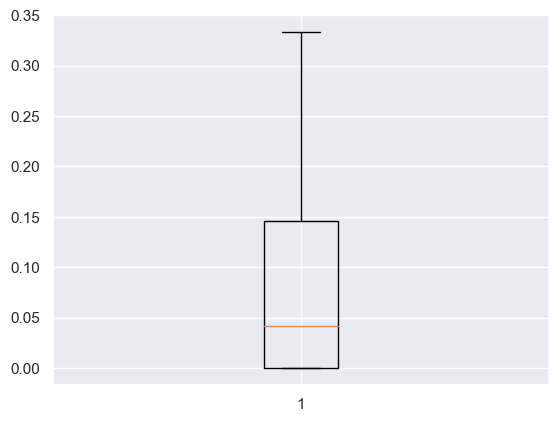

In [45]:
plt.boxplot(accuracies)
plt.show()

### 5-  Decision tree algorithm using libraries

### 6-  Detailed analysis